In [1]:
import sys
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental")
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet")
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental/amsr")
from lightning_train import DatasetAMSR, OverfitDatasetAMSR, LitDiffusion
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os
import sys
import pandas as pd
import lightning.pytorch as pl
import wandb
from argparse import ArgumentParser
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint
from torchvision.ops.focal_loss import sigmoid_focal_loss
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler, HeunDiscreteScheduler
import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import lightning.pytorch as pl
from torchmetrics import MetricCollection
from utils import BinaryAccuracy, SIEError, SIAError, RMSError, MAError, compute_spectrum2d
from utils import IceNetDataSetPyTorch, IterableIceNetDataSetPyTorch
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.cm import viridis

2025-01-29 16:59:22.955942: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 16:59:25.109777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 16:59:25.109864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 16:59:25.125952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 16:59:25.221216: I tensorflow/core/platform/cpu_feature_guar

In [2]:
path = "/data/hpcdata/users/anddon76/icenet/icenet-experimental/amsr/results/amsr-rothera-dataset_config.ice_only_lag_two.json-diffusion-ddpm1000-v_prediction-res-False-epoch=44-val_mse=0.0104.ckpt"
model = LitDiffusion.load_from_checkpoint(path)
model

LitDiffusion(
  (model): UNet2DModel(
    (conv_in): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlineari

In [9]:
test_dataset = DatasetAMSR("/data/hpcdata/users/anddon76/icenet/icenet-experimental/processed/amsr_rothera", "20200703", "20201231")
dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch size 1 here so we can ensemble with batch size
for batch in dataloader:
    x, y, sample_weight, dates = batch
    x = x.to(model.device)
    y = y.to(model.device)
    sample_weight = sample_weight.to(model.device)
    samples = []

    # generate ensemble in batch dimension
    noisy_y = torch.randn(32, model.out_channels,
                          model.resolution, model.resolution).to(model.device)
    x = x[[0]].repeat(32, 1, 1, 1).to(model.device)  # copy same x conditions to num_samples size batch
    model.noise_scheduler.set_timesteps(model.num_inference_timesteps)

    for t in tqdm(model.noise_scheduler.timesteps):
        with torch.no_grad():
            pred = model.forward(noisy_y, t, x)
        noisy_y = model.noise_scheduler.step(pred, t, noisy_y).prev_sample

    if model.forecast_residuals:
        noisy_y = noisy_y + x[:, [0], :, :]  # add on most recent ice condition (b, t, h, w) to THIS PREDICTION

    samples.append(noisy_y)
    break  # only consider first batch for now 

100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


In [12]:
dates

('20200703',)

Damn, 5 minutes for one ensemble forecast step, that's a lot!

In [15]:
fcast_npy_cpu = samples[0].cpu().numpy()

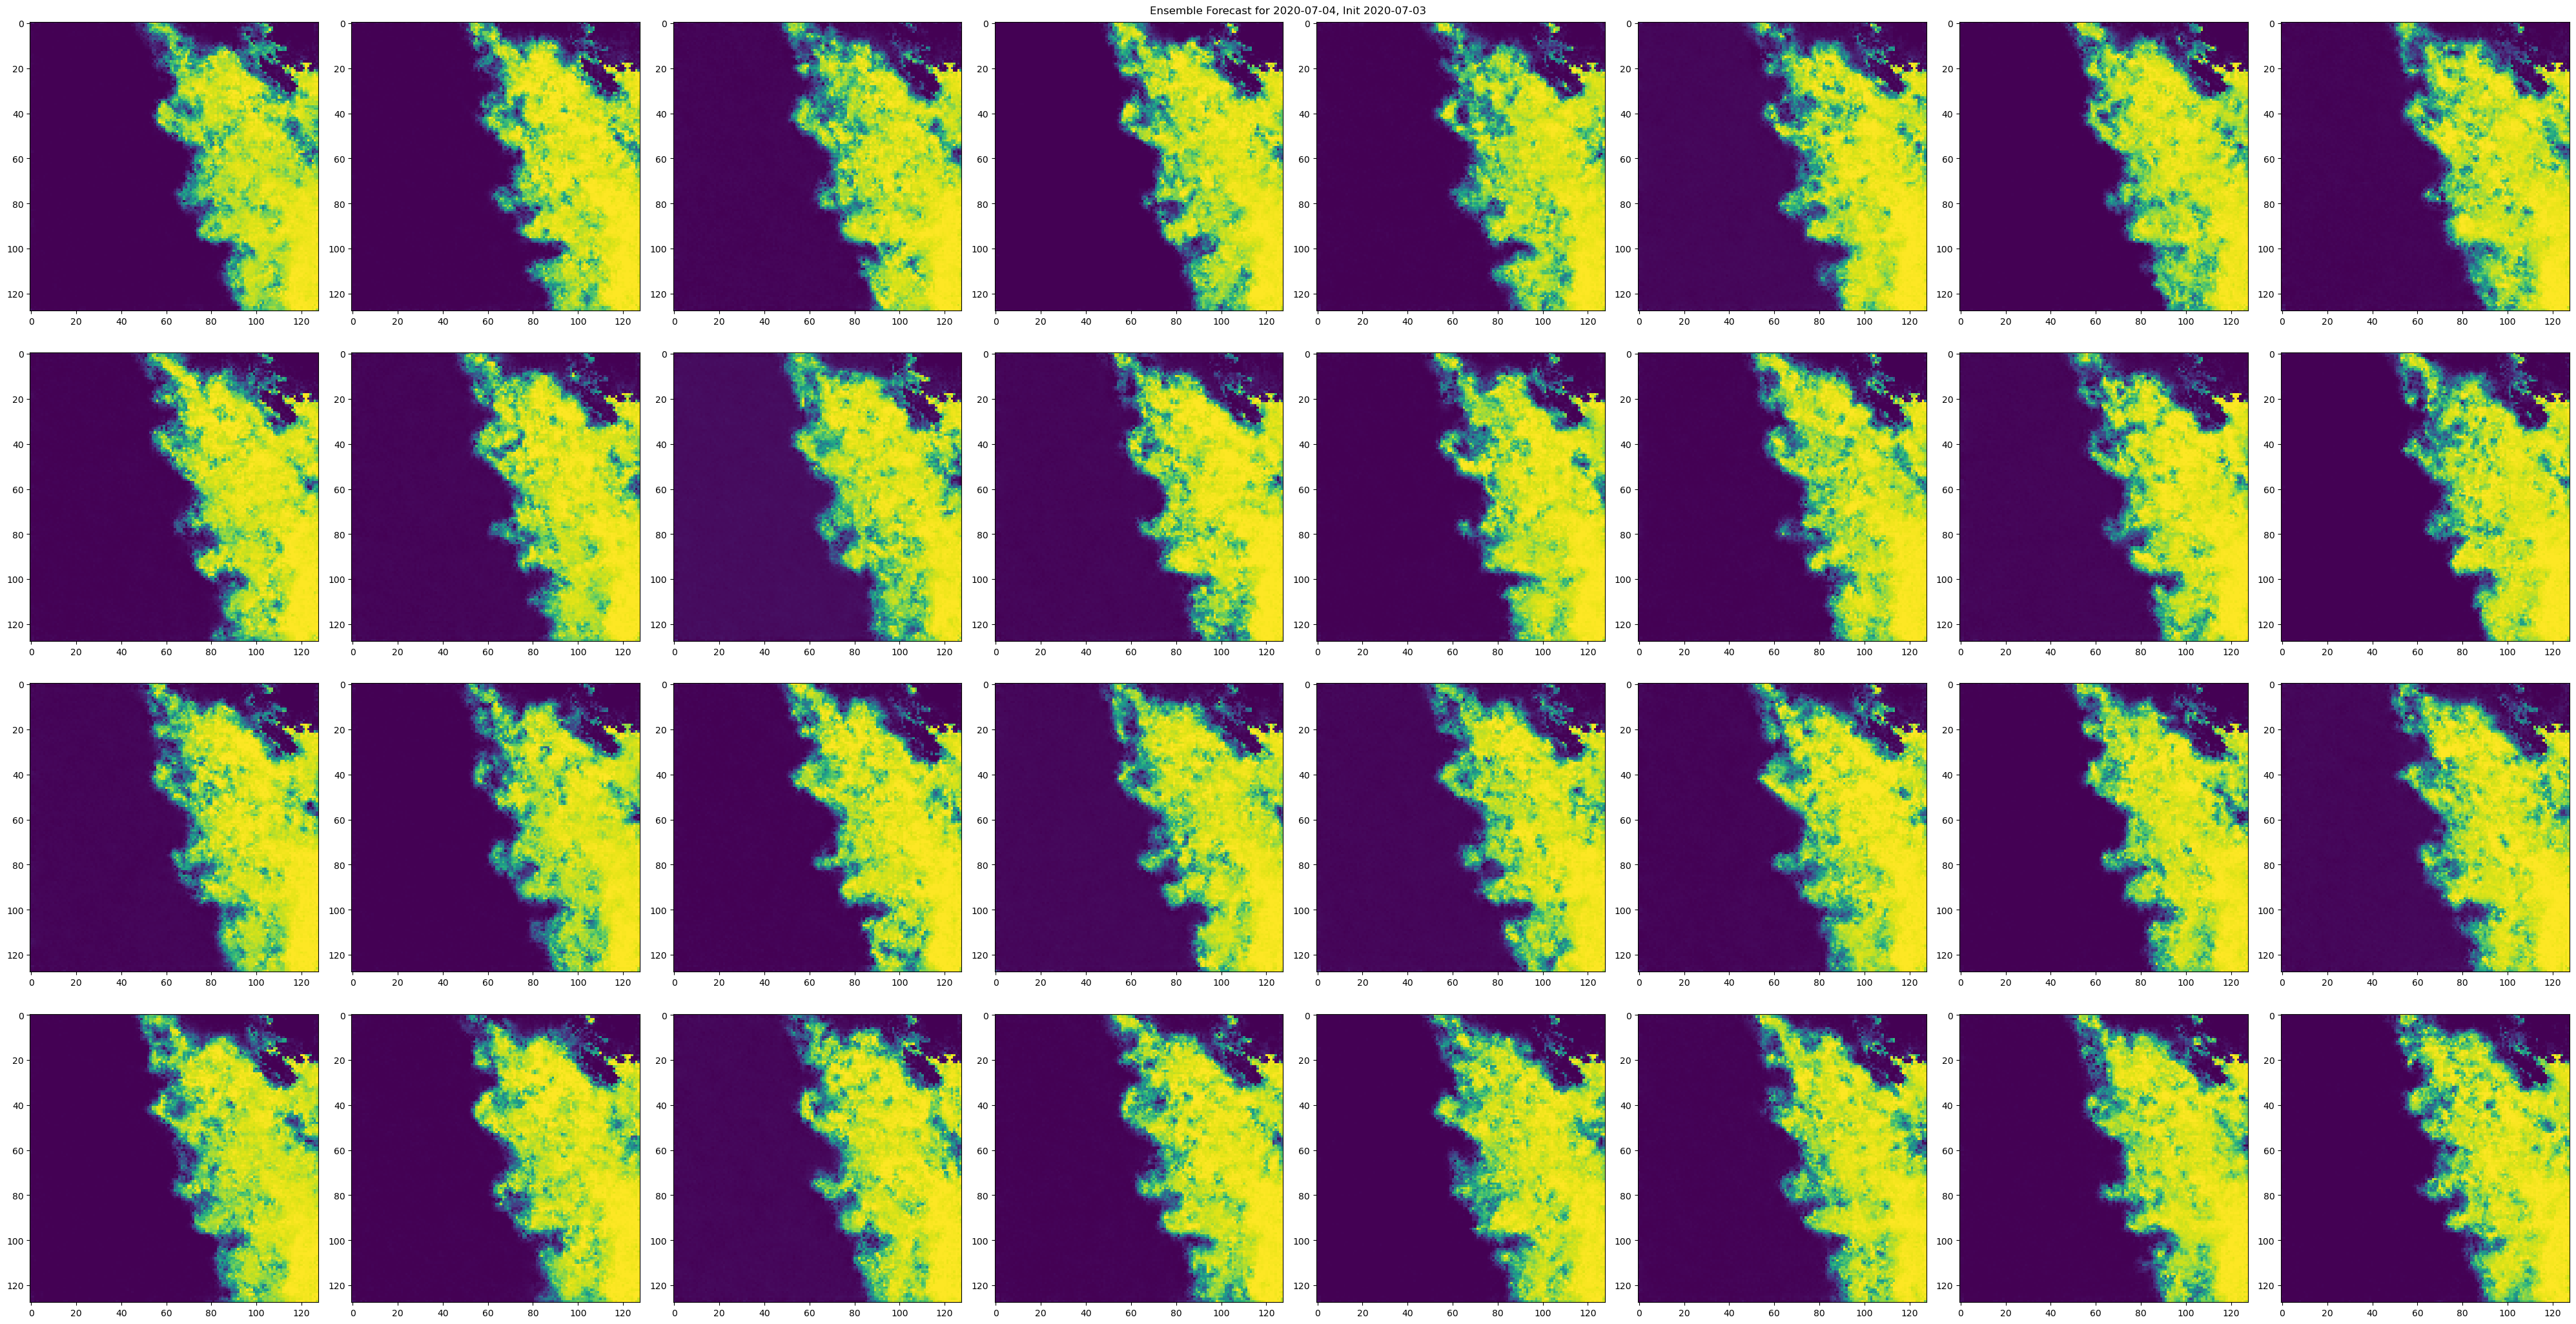

In [18]:
fig, ax = plt.subplots(4, 8, figsize=(40, 21))
ax = ax.ravel()
for i in range(32):
    ax[i].imshow(fcast_npy_cpu[i], vmin=0, vmax=1)
plt.suptitle("Ensemble Forecast for 2020-07-04, Init 2020-07-03")
plt.tight_layout()
plt.show()

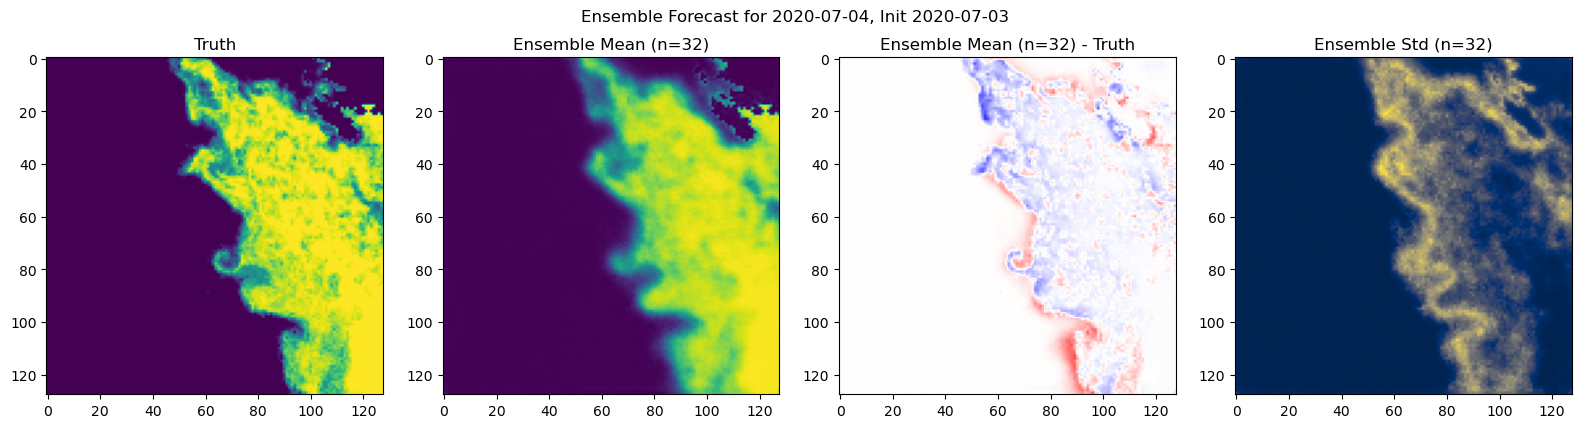

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4.2))
ax[0].imshow(y, vmin=0, vmax=1)
ax[0].set_title("Truth")
ax[1].imshow(fcast_npy_cpu.mean(axis=0), vmin=0, vmax=1)
ax[1].set_title("Ensemble Mean (n=32)")
ax[2].imshow(fcast_npy_cpu.mean(axis=0) - y, cmap="bwr", vmin=-1, vmax=1)
ax[2].set_title("Ensemble Mean (n=32) - Truth")
ax[3].imshow(fcast_npy_cpu.std(axis=0), cmap="cividis")
ax[3].set_title("Ensemble Std (n=32)")
plt.suptitle("Ensemble Forecast for 2020-07-04, Init 2020-07-03")
plt.tight_layout()
plt.show()

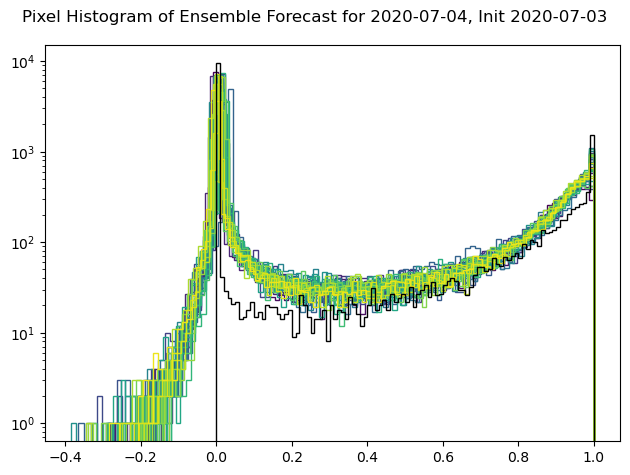

In [29]:
fig, ax = plt.subplots()      
for i in range(32):
    ax.hist(fcast_npy_cpu[i].ravel(), bins=100, histtype=u'step', log=True, label=f"{i}", color=viridis(i/32))
ax.hist(y.cpu().ravel(), bins=100, histtype=u'step', log=True, label=f"{i}", color="black")
plt.suptitle("Pixel Histogram of Ensemble Forecast for 2020-07-04, Init 2020-07-03")
plt.tight_layout()
plt.show()

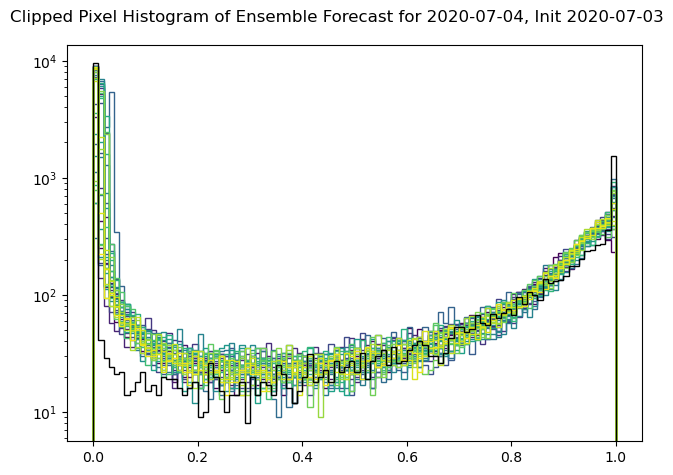

In [30]:
fig, ax = plt.subplots()      
for i in range(32):
    ax.hist(fcast_npy_cpu[i].ravel().clip(0, 1), bins=100, histtype=u'step', log=True, label=f"{i}", color=viridis(i/32))
ax.hist(y.cpu().ravel(), bins=100, histtype=u'step', log=True, label=f"{i}", color="black")
plt.suptitle("Clipped Pixel Histogram of Ensemble Forecast for 2020-07-04, Init 2020-07-03")
plt.tight_layout()
plt.show()

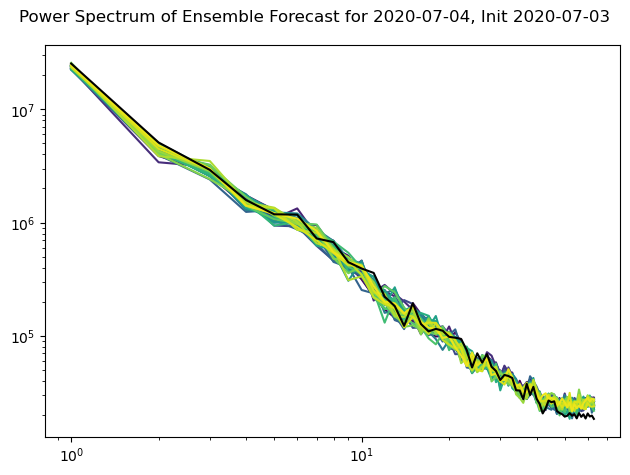

In [33]:
fig, ax = plt.subplots()      
for i in range(32):
    kvals, Abins = compute_spectrum2d(fcast_npy_cpu[i])
    ax.loglog(kvals, Abins, label=f"{i}", color=viridis(i/32))  
kvals, Abins = compute_spectrum2d(y.cpu())
ax.loglog(kvals, Abins, label=f"Truth", color="black")            
plt.suptitle("Power Spectrum of Ensemble Forecast for 2020-07-04, Init 2020-07-03")
plt.tight_layout()
plt.show()

In [35]:
for batch in dataloader:
    x, y, sample_weight, dates = batch
    x = x.to(model.device)
    y = y.to(model.device)
    sample_weight = sample_weight.to(model.device)
    samples = []
    break

In [38]:
start_date = pd.to_datetime(dates[0])
end_date = start_date + pd.Timedelta(30, "days")
start_date, end_date

(Timestamp('2020-07-03 00:00:00'), Timestamp('2020-08-02 00:00:00'))

In [42]:
ensemble_size = 32
days_to_rollout = 30

x = x[[0]].repeat(ensemble_size, 1, 1, 1).to(model.device)  # copy same x conditions to num_samples size batch
mask = torch.where(sample_weight[0] > 0, 1, 0).to(model.device)
start_date = pd.to_datetime(dates[0])
end_date = start_date + pd.Timedelta(days_to_rollout, "days")
date_range = pd.date_range(start_date, end_date)
forecast = []

# iterate over days
for date in tqdm(date_range):

    # sample rollout
    noisy_y = torch.randn(ensemble_size, model.out_channels,
                          model.resolution, model.resolution).to(model.device)
    for t in tqdm(model.noise_scheduler.timesteps):
        with torch.no_grad():
            pred = model.forward(noisy_y, t, x)
        noisy_y = model.noise_scheduler.step(pred, t, noisy_y).prev_sample
    
    if model.forecast_residuals:
        noisy_y = noisy_y + x[:, [0]] # add on most recent ice condition (b, t, h, w) to THIS PREDICTION

    # post process sample
    noisy_y = noisy_y.clip(0, 1)  # TODO reconsider clipping SIC is bounded between 0 and 1
    noisy_y = noisy_y * mask  # mask out land and midlatitude ocean
    # noisy_y = torch.where(noisy_y < self.min_sic_threshold, 0, noisy_y)  # clip residual noise DONT DO THIS FOR range -1, +1
    forecast.append(noisy_y)

    # get next step's contextual predictors (without "cheating" i.e. we discard ice info)
    next_date = date + pd.Timedelta(1, "day")
    next_f = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/processed/amsr_rothera/{next_date.strftime('%Y%m%d')}.npy"
    next_sample = np.load(next_f)
    next_context = torch.from_numpy(next_sample[3:]).nan_to_num().to(torch.float).to(model.device)
    next_context = next_context.repeat(ensemble_size, 1, 1, 1)  # broadcast copies for ensemble

    # note sample = [ice_t, ice_t_1, ice_t_2, clim, land, cos, sin]
    # note x = [ice_t_1, ice_t_2, clim, land, cos, sin]            
    x = torch.cat((
        noisy_y,   # set ice_t -> ice_t_1 from prediction
        x[:, [0]],  # set ice_t_1 -> ice_t_2 from last predictor
        next_context, # climatology, land, and cos/sin embeddings for next day without
    ), dim=1)  # update to next timestep, t is first, t-1 is second
    x = x.to(dtype=torch.float32)
    
# concatenate into forecast
forecast = torch.cat(forecast, dim=1).to(model.device)

# compile ground truth and climatology
# note from dataset creation sample = np.array([ice_t, ice_t_1, ice_t_2, clim, land, cos, sin])
truth, clim = [], []
date = start_date
while date <= end_date:
    f = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/processed/amsr_rothera/{date.strftime('%Y%m%d')}.npy"
    sample = np.load(f)
    truth.append(sample[0])  # ice_t is first element of sample
    clim.append(sample[3])  # clim is fourth element of sample
    date = date + pd.Timedelta(1, "day")
truth = torch.from_numpy(np.array(truth)).nan_to_num().to(torch.float).to(model.device)
clim = torch.from_numpy(np.array(clim)).nan_to_num().to(torch.float).to(model.device)


 35%|███▌      | 11/31 [59:36<1:48:21, 325.10s/it]


KeyboardInterrupt: 

In [45]:
# concatenate into forecast
forecast = torch.cat(forecast, dim=1).to(model.device)

# compile ground truth and climatology
# note from dataset creation sample = np.array([ice_t, ice_t_1, ice_t_2, clim, land, cos, sin])
truth, clim = [], []
date = start_date
i = 0
while i < 11:
    f = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/processed/amsr_rothera/{date.strftime('%Y%m%d')}.npy"
    sample = np.load(f)
    truth.append(sample[0])  # ice_t is first element of sample
    clim.append(sample[3])  # clim is fourth element of sample
    date = date + pd.Timedelta(1, "day")
    i += 1
truth = torch.from_numpy(np.array(truth)).nan_to_num().to(torch.float).to(model.device)
clim = torch.from_numpy(np.array(clim)).nan_to_num().to(torch.float).to(model.device)

In [49]:
path = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/amsr/results/july2020_11day_32member"
os.makedirs(path, exist_ok=True)
np.save(f"{path}/forecast.npy", forecast.cpu().numpy())
np.save(f"{path}/truth.npy", truth.cpu().numpy())
np.save(f"{path}/clim.npy", clim.cpu().numpy())
np.savetxt(f"{path}/dates.txt", date_range, fmt="%s")

In [3]:
path = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/amsr/results/jul2021_30day_32member"
forecast = np.load(f"{path}/forecast.npy")
truth = np.load(f"{path}/truth.npy")
clim = np.load(f"{path}/clim.npy")
mask = np.load(f"{path}/mask.npy")
dates = np.loadtxt(f"{path}/dates.txt", dtype=datetime)

In [3]:
forecast.shape, truth.shape, clim.shape, dates.shape

((32, 30, 128, 128), (30, 128, 128), (30, 128, 128), (30,))

In [3]:
dates

array(['2021-01-01T00:00:00.000000000', '2021-01-02T00:00:00.000000000',
       '2021-01-03T00:00:00.000000000', '2021-01-04T00:00:00.000000000',
       '2021-01-05T00:00:00.000000000', '2021-01-06T00:00:00.000000000',
       '2021-01-07T00:00:00.000000000', '2021-01-08T00:00:00.000000000',
       '2021-01-09T00:00:00.000000000', '2021-01-10T00:00:00.000000000',
       '2021-01-11T00:00:00.000000000', '2021-01-12T00:00:00.000000000',
       '2021-01-13T00:00:00.000000000', '2021-01-14T00:00:00.000000000',
       '2021-01-15T00:00:00.000000000', '2021-01-16T00:00:00.000000000',
       '2021-01-17T00:00:00.000000000', '2021-01-18T00:00:00.000000000',
       '2021-01-19T00:00:00.000000000', '2021-01-20T00:00:00.000000000',
       '2021-01-21T00:00:00.000000000', '2021-01-22T00:00:00.000000000',
       '2021-01-23T00:00:00.000000000', '2021-01-24T00:00:00.000000000',
       '2021-01-25T00:00:00.000000000', '2021-01-26T00:00:00.000000000',
       '2021-01-27T00:00:00.000000000', '2021-01-28

In [38]:
pd.to_datetime(dates[0]) - pd.Timedelta(1, "day")

Timestamp('2021-06-30 00:00:00')

In [30]:
# create imshow video
start_date = pd.to_datetime(dates[0])
fps = 3
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
ax = ax.ravel()
def img_update(step):
    fc_1.set_data(forecast[0][step])
    fc_2.set_data(forecast[1][step])
    fc_3.set_data(forecast[2][step])
    fc_4.set_data(forecast[3][step])
    fc_std.set_data(forecast.std(axis=0)[step])
    fc_mean.set_data(forecast.mean(axis=0)[step])
    fc_clim.set_data(clim[step])
    fc_true.set_data(truth[step])
    fc_diff.set_data((truth[step] - forecast.mean(axis=0)[step]))
    title.set_text(f"Rollout Step {step+1} | Init {start_date} | Valid {start_date + pd.Timedelta(step+1, 'D')}")

fc_1 = ax[0].imshow(forecast[0][0], vmin=0, vmax=1, animated=True)
ax[0].set_title("Ensemble Member 1")
fc_2 = ax[1].imshow(forecast[1][0], vmin=0, vmax=1, animated=True)
ax[1].set_title("Ensemble Member 2")
fc_3 = ax[2].imshow(forecast[2][0], vmin=0, vmax=1, animated=True)
ax[2].set_title("Ensemble Member 3")
fc_4 = ax[3].imshow(forecast[3][0], vmin=0, vmax=1, animated=True)
ax[3].set_title("Ensemble Member 4")
fc_std = ax[4].imshow(forecast.std(axis=0)[0], cmap="cividis", animated=True)
ax[4].set_title("Ensemble Std")
fc_mean = ax[5].imshow(forecast.mean(axis=0)[0], vmin=0, vmax=1, animated=True)
ax[5].set_title("Ensemble Mean")
fc_clim = ax[6].imshow(clim[0], vmin=0, vmax=1, animated=True)
ax[6].set_title("Linear Trend Forecast")
fc_true = ax[7].imshow(truth[0], vmin=0, vmax=1, animated=True)
ax[7].set_title("Truth")
fc_diff = ax[8].imshow((truth[0] - forecast.mean(axis=0)[0]), vmin=-1, vmax=1, cmap="bwr", animated=True)
ax[8].set_title("(Truth - Ensemble Mean)")
ax[9].axis("off")
title = plt.suptitle(f"Rollout Step 1 | Init {start_date} | Valid {start_date + pd.Timedelta(1, 'D')}")
plt.tight_layout()
animation = FuncAnimation(fig, img_update, range(len(dates)), interval=1000 / fps)
plt.close()
animation.save("temp2.mp4", fps=fps)

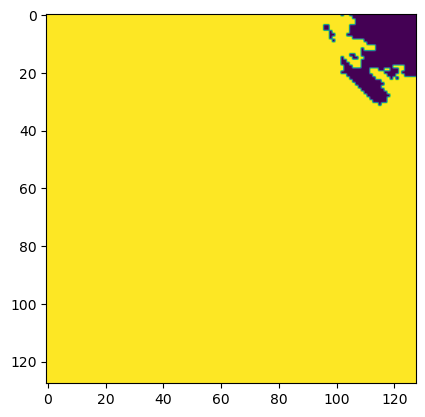

In [45]:
test_dataset = DatasetAMSR("/data/hpcdata/users/anddon76/icenet/icenet-experimental/processed/amsr_rothera", "20210701", "20210731")
dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch size 1 here so we can ensemble with batch size
for batch in dataloader:
    x, y, sample_weight, dates = batch
    break

mask = np.where(sample_weight > 0, 1, 0)
np.save(f"{path}/mask.npy", mask)
plt.imshow(mask.squeeze())

## Debug ice edge code
From icenet/model/utils

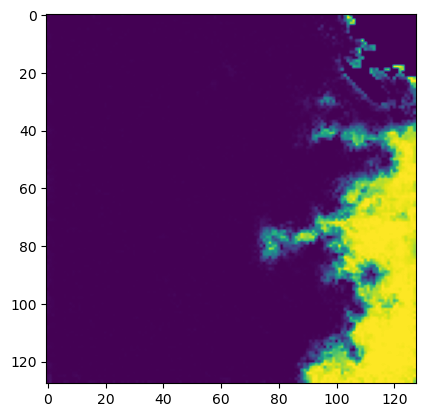

In [4]:
plt.imshow(forecast[0][0])

/tmp/ipykernel_35568/1358498675.py:10: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for p in cs.collections[0].get_paths():


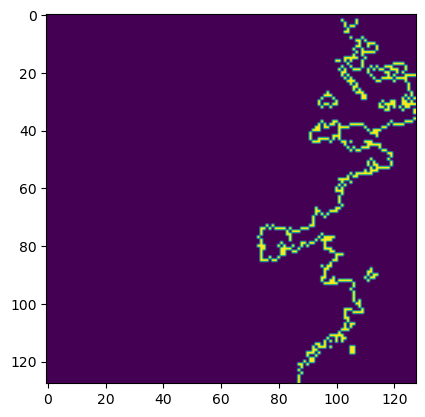

In [5]:
def arr_to_ice_edge_arr(arr: object, thresh: object, land_mask: object) -> object:

    X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    X = X.T
    Y = Y.T

    cs = plt.contour(X, Y, arr, [thresh], alpha=0)  # Do not plot on any axes
    x = []
    y = []
    for p in cs.collections[0].get_paths():
        x_i, y_i = p.vertices.T
        x.extend(np.round(x_i))
        y.extend(np.round(y_i))
    x = np.array(x, int)
    y = np.array(y, int)
    ice_edge_arr = np.zeros(arr.shape, dtype=bool)
    ice_edge_arr[x, y] = True
    # Mask out ice edge contour that hugs the coastline
    ice_edge_arr[land_mask] = False
    return ice_edge_arr

ice_edge_arr = arr_to_ice_edge_arr(forecast[0][0], 0.15, mask)
plt.imshow(ice_edge_arr)

Compute edge length? Just an idea.... also normalised edge length like in Oslo thesis?

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_35568/1358498675.py:10: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for p in cs.collections[0].get_paths():
100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


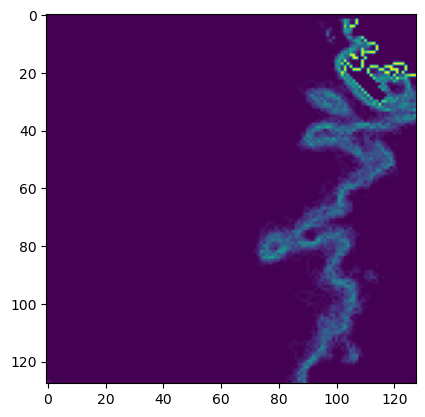

In [6]:
ice_edge_arr = np.zeros(forecast.shape[1:])
for member in tqdm(range(32)):
    for t in range(30):
        ice_edge_arr[t] += arr_to_ice_edge_arr(forecast[member][t], 0.15, mask)
plt.imshow(ice_edge_arr[0])

In [35]:
path

'/data/hpcdata/users/anddon76/icenet/icenet-experimental/amsr/results/jan2021_30day_32member'

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
fps = 3
def rollout_edge_update(step):
    f.set_data(ice_edge_arr[step])
    title.set_text(f"Rollout Step {step+1} | Init {pd.to_datetime(dates[0]) - pd.Timedelta(1, 'D')} | Valid {dates[step]}")
f = ax.imshow(ice_edge_arr[0], animated=True)
title = plt.suptitle(f"Rollout Step 1 | Init {pd.to_datetime(dates[0]) - pd.Timedelta(1, 'D')} | Valid {dates[0]}")
plt.tight_layout()
animation = FuncAnimation(fig, rollout_edge_update, range(len(dates)), interval=1000 / fps)
plt.close()
animation.save(f"{path}/rollout_edge.mp4", fps=fps)

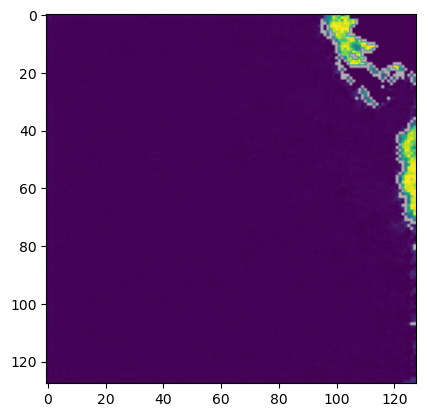

In [7]:
plt.imshow(forecast[0][0])
im2 = np.ones(ice_edge_arr.shape + (4,)) * 0.7
im2[:, :, 3] = ice_edge_arr # assuming lattice is already a bool array
plt.imshow(im2)

/tmp/ipykernel_35568/257757426.py:10: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for p in cs.collections[0].get_paths():


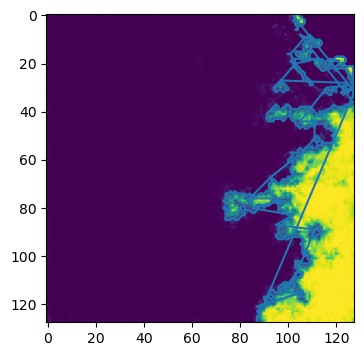

In [16]:
def arr_to_ice_edge_poly(arr: object, thresh: object, land_mask: object) -> object:

    X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    # X = X.T
    # Y = Y.T

    cs = plt.contour(X, Y, arr, [thresh], alpha=0)
    x = []
    y = []
    for p in cs.collections[0].get_paths():
        x_i, y_i = p.vertices.T
        x.extend(np.round(x_i))
        y.extend(np.round(y_i))
    return x, y

fig, ax = plt.subplots(figsize=(4, 4))
x, y = arr_to_ice_edge_poly(forecast[0][0], 0.15, mask)
plt.imshow(forecast[0][0])
plt.plot(x, y)

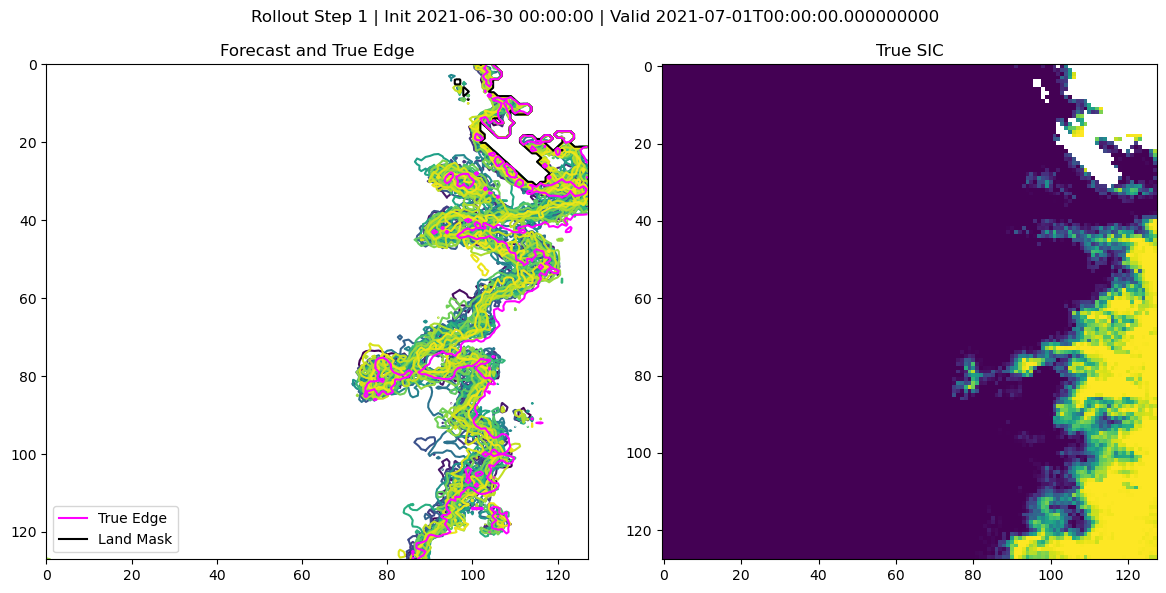

In [62]:
from matplotlib.cm import viridis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# forecasts
for member in range(32):
    arr = forecast[member, 0]
    X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    ax[0].contour(X, Y, arr, [0.15], colors=[viridis(member/32)])
# landmask
ax[0].contour(X, Y, mask, [0.15], colors=["black"])
# groundtruth
cs = ax[0].contour(X, Y, truth[0], [0.15], colors=["magenta"])
ax[0].set_title("Forecast and True Edge")
ax[0].invert_yaxis()
ax[0].plot(0, 0, color="magenta", label="True Edge")  # hack to get plot label
ax[0].plot(0, 0, color="black", label="Land Mask")  # hack to get plot label
ax[0].legend(loc="lower left")
# plot true ice for reference
ax[1].imshow(np.where(mask, truth[0], np.nan))
ax[1].set_title("True SIC")
title = plt.suptitle(f"Rollout Step 1 | Init {pd.to_datetime(dates[0]) - pd.Timedelta(1, 'D')} | Valid {dates[0]}")
plt.tight_layout()
plt.show()

In [76]:
# edge animation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fps = 3
def rollout_edge_update(step):
    for artist in ax[0].collections:
        artist.remove()
    for member in range(32):
        arr = forecast[member, step]
        X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
        ax[0].contour(X, Y, arr, [0.15], colors=[viridis(member/32)])
    # landmask
    ax[0].contour(X, Y, mask, [0.15], colors=["black"])
    # groundtruth
    ax[0].contour(X, Y, truth[step], [0.15], colors=["magenta"])
    im.set_data(np.where(mask, truth[step], np.nan))
    title.set_text(f"Rollout Step {step+1} | Init {pd.to_datetime(dates[0]) - pd.Timedelta(1, 'D')} | Valid {dates[step]}")


# forecasts
for member in range(32):
    arr = forecast[member, 0]
    X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    ax[0].contour(X, Y, arr, [0.15], colors=[viridis(member/32)])
# landmask
ax[0].contour(X, Y, mask, [0.15], colors=["black"])
# groundtruth
ax[0].contour(X, Y, truth[0], [0.15], colors=["magenta"])
ax[0].set_title("Forecast and True Edge")
ax[0].invert_yaxis()
ax[0].plot(0, 0, color="magenta", label="True Edge")  # hack to get plot label
ax[0].plot(0, 0, color="black", label="Land Mask")  # hack to get plot label
ax[0].legend(loc="lower left")
# plot true ice for reference
im = ax[1].imshow(np.where(mask, truth[0], np.nan))
ax[1].set_title("True SIC")
title = plt.suptitle(f"Rollout Step 1 | Init {pd.to_datetime(dates[0]) - pd.Timedelta(1, 'D')} | Valid {dates[0]}")
plt.tight_layout()
animation = FuncAnimation(fig, rollout_edge_update, range(len(dates)), interval=1000 / fps)
plt.close()
animation.save(f"{path}/rollout_edge.mp4", fps=fps)

In [2]:
# for month in tqdm(["dec"]): #"jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov"]):
# path = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/amsr/results/{month}2021_30day_32member"
path = f"/data/hpcdata/users/anddon76/icenet/icenet-experimental/amsr/results/lownoise_sep2021_30day_32member"
forecast = np.load(f"{path}/forecast.npy")
truth = np.load(f"{path}/truth.npy")
clim = np.load(f"{path}/clim.npy")
mask = np.load(f"{path}/mask.npy")
dates = np.loadtxt(f"{path}/dates.txt", dtype=datetime)

# edge animation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fps = 3
def rollout_edge_update(step):
    for artist in ax[0].collections:
        artist.remove()
    for member in range(32):
        arr = forecast[member, step]
        X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
        ax[0].contour(X, Y, arr, [0.15], colors=[viridis(member/32)])
    # landmask
    ax[0].contour(X, Y, mask, [0.15], colors=["black"])
    # groundtruth
    ax[0].contour(X, Y, truth[step], [0.15], colors=["magenta"])
    im.set_data(np.where(mask, truth[step], np.nan))
    title.set_text(f"Rollout Step {step+1} | Init {pd.to_datetime(dates[0]) - pd.Timedelta(1, 'D')} | Valid {dates[step]}")


# forecasts
for member in range(32):
    arr = forecast[member, 0]
    X, Y = np.meshgrid(np.arange(arr.shape[0]), np.arange(arr.shape[1]))
    ax[0].contour(X, Y, arr, [0.15], colors=[viridis(member/32)])
# landmask
ax[0].contour(X, Y, mask, [0.15], colors=["black"])
# groundtruth
ax[0].contour(X, Y, truth[0], [0.15], colors=["magenta"])
ax[0].set_title("Forecast and True Edge")
ax[0].invert_yaxis()
ax[0].plot(0, 0, color="magenta", label="True Edge")  # hack to get plot label
ax[0].plot(0, 0, color="black", label="Land Mask")  # hack to get plot label
ax[0].legend(loc="lower left")
# plot true ice for reference
im = ax[1].imshow(np.where(mask, truth[0], np.nan))
ax[1].set_title("True SIC")
title = plt.suptitle(f"Rollout Step 1 | Init {pd.to_datetime(dates[0]) - pd.Timedelta(1, 'D')} | Valid {dates[0]}")
plt.tight_layout()
animation = FuncAnimation(fig, rollout_edge_update, range(len(dates)), interval=1000 / fps)
plt.close()
animation.save(f"{path}/rollout_edge.mp4", fps=fps)